# COMPARISON LIRPA VS DECOMON: FULLY CONNECTED MNIST

# PART A: TENSORFLOW

In [1]:
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.datasets import mnist
import sys
sys.path.append('..')
import os.path
import os
import pickle as pkl
from contextlib import closing
import time
from numpy.testing import assert_almost_equal,  assert_array_less

In [2]:
import os
import tensorflow.keras as keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, Activation, Reshape, \
Conv2D, Add, Flatten, Dense, Layer, MaxPooling2D, Subtract, Concatenate, Multiply, Add, Subtract
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
print('Notebook run using keras:', keras.__version__)
import sys
sys.path.append('../..')
import decomon
from decomon.models.convert import clone as convert
from decomon import get_upper_box, get_lower_box, get_range_box, get_range_noise

Notebook run using keras: 2.4.0


In [3]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

### Build and Train a Neural Network on a sinusoide

The sinusoide funtion is defined on a $[-1 ; 1 ]$ interval. We put a factor in the sinusoide to have several periods of oscillations. 


In [4]:
x = np.linspace(-1, 1, 1000)
y = np.sin(10*x)

We approximate this funciton by a fully connected network composed of 4 hidden layers of size 100, 100, 20 and 20 respectively. Rectified Linear Units (ReLU) are chosen as activation functions for all the neurons. 

In [5]:
layers = []
layers.append(Dense(100, activation='linear', input_dim=1)) # specify the dimension of the input space
layers.append(Activation('relu'))
layers.append(Dense(100, activation='linear'))
layers.append(Activation('relu'))
layers.append(Dense(20, activation='linear'))
layers.append(Activation('relu'))
layers.append(Dense(20, activation='linear'))
layers.append(Activation('relu'))
layers.append(Dense(1, activation='linear'))
model = Sequential(layers)

we specify the optimization method and the metric, in this case a classical Means Square Error. 

In [6]:
model.compile('adam', 'mse')

we train the neural network

In [7]:
model.fit(x, y, batch_size=32, shuffle=True, epochs=100, verbose=0) 
# verbose=0 removes the printing along the training

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

In [18]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.hidden_0 = nn.Linear(1, 100) # input_dim = 1; output_dim = 100
        self.hidden_1 = nn.Linear(100, 100)
        self.hidden_2 = nn.Linear(100, 20)
        self.hidden_3 = nn.Linear(20, 20)
        self.hidden_4 = nn.Linear(1, 20)
        
        self.layers = [self.hidden_0, self.hidden_1, self.hidden_2, self.hidden_3, self.hidden_4]

    def forward(self, x):
        x = self.hidden_0(x)
        x = F.relu(x)
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.hidden_3(x)
        x = F.relu(x)
        x = self.hidden_4(x)
        return x
        #x = x.view(-1, 128)
        #return x
        
    def reset_weights(self, model):
        
        layers = model.layers
        index=0
        for layer_keras in layers:
            if len(layer_keras.get_weights()):
                print(layer_keras.name)
                layer_torch = self.layers[index]
                weights = layer_keras.get_weights()
                layer_torch.weight.data = torch.from_numpy(np.transpose(weights[0]))
                layer_torch.bias.data = torch.from_numpy(np.transpose(weights[1]))
                index+=1         
            

In [19]:
model_torch = NeuralNet()
model_torch.reset_weights(model)

dense
dense_1
dense_2
dense_3
dense_4


In [20]:
model_torch.reset_weights(model)

dense
dense_1
dense_2
dense_3
dense_4


In [21]:
# convert our model into a decomon model:
decomon_model_0 = convert(model, method='crown-ibp')
decomon_model_1 = convert(model, ibp=True, forward=False, method='crown')

### check the predictions

In [22]:
x_train_tensor = torch.from_numpy(x[:,None]).float().to('cpu')
y_pred_torch = model_torch(x_train_tensor).cpu().detach().numpy()

In [23]:
y_pred_torch = model_torch(x_train_tensor).cpu().detach().numpy()
y_pred_keras = model.predict(x)

In [24]:
assert_almost_equal(y_pred_keras, y_pred_torch, decimal=6)

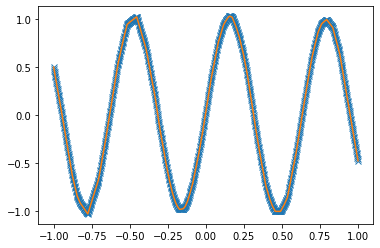

In [25]:
plt.plot(x, y_pred_torch, 'x')
plt.plot(x, y_pred_keras)

# AUTO LIRPA

In [26]:
# define the intervals

def get_range_box_comparison(method, model_decomon_1, model_torch,  x_min=x.min(), x_max=x.max(), n_split=10):

    alpha = np.linspace(0, 1, n_split+1)
    x_samples = (1-alpha)*x_min + alpha*x_max
    X_min = x_samples[:-1][:, None]
    X_max = x_samples[1:][:, None]
    X_lirpa_ = (X_min + X_max)/2.
    eps = 0.5*(x_max - x_min)/n_split    

    # convert X_lirpa into a pytorch tensor
    X_lirpa = torch.from_numpy(X_lirpa_).float().to('cpu')

    model_lirpa = BoundedModule(model_torch, X_lirpa)
    ptb = PerturbationLpNorm(norm=np.inf, eps=eps)
    input_lirpa = BoundedTensor(X_lirpa, ptb)

    if method=='crown':
        IBP=False
    else:
        IBP=True

    lb, ub = model_lirpa.compute_bounds(x=(input_lirpa,), IBP=IBP, method=method)

    lb_ = lb.cpu().detach().numpy()
    ub_ = ub.cpu().detach().numpy()
    
    #upper_0, lower_0 = get_range_noise(model_decomon_0, X_lirpa_, eps, p=np.inf)
    upper_, lower_ = get_range_box(model_decomon_1, X_min, X_max, fast=True)
    #upper_ = np.minimum(upper_0, upper_0)
    #lower_ = np.maximum(lower_1, lower_1)
    
    return X_lirpa_, model.predict(X_lirpa_), lb_, ub_, lower_, upper_

In [27]:
x_samples, y_samples, lb_p_0, ub_p_0, lb_t_0, ub_t_0 = get_range_box_comparison('crown-ibp', decomon_model_0, model_torch, n_split=10)

In [28]:
x_samples, y_samples, lb_p_1, ub_p_1, lb_t_1, ub_t_1 = get_range_box_comparison('crown', decomon_model_1, model_torch, n_split=10)

In [29]:
ub_p_0 - ub_t_0

array([[ 9.5367432e-07],
       [ 1.3113022e-06],
       [ 7.1525574e-07],
       [-4.7683716e-07],
       [ 0.0000000e+00],
       [ 4.7683716e-07],
       [-1.9073486e-06],
       [ 2.3841858e-07],
       [ 1.4305115e-06],
       [ 9.5367432e-07]], dtype=float32)

In [30]:
assert_almost_equal(ub_p_0, ub_t_0, decimal=5)

In [31]:
assert_almost_equal(lb_p_0, lb_t_0, decimal=5)

In [33]:
assert_almost_equal(lb_p_1, lb_t_1, decimal=5)

In [34]:
assert_almost_equal(ub_p_1, ub_t_1, decimal=5)